In [1]:
from collections import defaultdict
import glob
from time import time

import numpy as np
import pandas as pd
import networkx as nx
from new_SPOC import *
import old_SPOC
from generate_SPOC_model import *
import matplotlib.pyplot as plt
#import matlab.engine
from tqdm import tqdm_notebook
from IPython.display import clear_output, display

%matplotlib inline

import random
random.seed(42)
np.random.seed(42)

#eng = matlab.engine.start_matlab()

In [2]:
def load_data(adjacency_filepath, community_filepath):
    G=nx.read_edgelist(adjacency_filepath, nodetype=int)
    nodelist = list(G.nodes())
    node2indx = {n: i for i, n in enumerate(nodelist)}
    A = nx.to_scipy_sparse_matrix(G, nodelist=nodelist)
    comms = {}

    with open(community_filepath) as f:
        for line in f:
            args = line.split()
            k = int(args[1]) - 1
            if k not in comms:
                comms[k] = ([], [])
            comms[k][0].append(node2indx[int(args[0])])
            comms[k][1].append(float(args[2]))

    comm_count = len(comms)
    comms_array = np.zeros((A.shape[0], comm_count))
    for i in range(comm_count):
        comms_array[comms[i][0], i] = comms[i][1]
    return nodelist, A, comms_array

In [ ]:
data_paths = glob.glob('./data/coauthorship/*_adjacency.txt')
data_paths = [(adj, adj.replace("adjacency", "community"))for adj in data_paths]
print("\n".join("{}, {}".format(*data) for data in data_paths))

./data/coauthorship/DBLP5_adjacency.txt, ./data/coauthorship/DBLP5_community.txt
./data/coauthorship/DBLP1_adjacency.txt, ./data/coauthorship/DBLP1_community.txt
./data/coauthorship/DBLP4_adjacency.txt, ./data/coauthorship/DBLP4_community.txt
./data/coauthorship/MAG2_adjacency.txt, ./data/coauthorship/MAG2_community.txt
./data/coauthorship/MAG1_adjacency.txt, ./data/coauthorship/MAG1_community.txt
./data/coauthorship/DBLP3_adjacency.txt, ./data/coauthorship/DBLP3_community.txt
./data/coauthorship/DBLP2_adjacency.txt, ./data/coauthorship/DBLP2_community.txt


#### SPOC methods from A matrix

In [ ]:
methods = {"SPOC": lambda A, n_clusters: SPOC(A, n_clusters, use_ellipsoid=False, use_cvxpy=False),
           #"SPOC_old": lambda A, n_clusters: old_SPOC.SPOC(A, n_clusters),
           "SPOC_bootstrap": lambda A, n_clusters: SPOC_bootstrap(A, n_clusters, n_repetitions=150, std_num=3),
          }

results = []
for method_name in methods:
    print('\t', method_name)
    for data in data_paths:
        print(time())
        nodelist, A, comms = load_data(*data)
        n_clusters = comms.shape[1]
        print(data, '...', 'clusters:', n_clusters, "nodes: ", A.shape[0])
        time_start = time()
        theta, b = methods[method_name](A, n_clusters)
        time_end = time()
        res = {"relative MSE": find_permutation_Theta(comms, theta)[0], 
               "Mean Spearman coefficient": find_permutation_spearmanr(comms, theta)[0],
               "Method": method_name,
               "Dataset": data[0].split("/")[-1].split("_")[0],
               "cluster #": n_clusters, 
               "node #": A.shape[0],
               "time (sec)": time_end - time_start,
              }
        results.append(res)
        print(res)

	 SPOC
1505162081.774903
('./data/coauthorship/DBLP5_adjacency.txt', './data/coauthorship/DBLP5_community.txt') ... clusters: 4 nodes:  42351
{'cluster #': 4, 'Method': 'SPOC', 'Dataset': 'DBLP5', 'node #': 42351, 'relative MSE': 0.8514250972200097, 'time (sec)': 2.5185492038726807, 'Mean Spearman coefficient': 0.13115661771943771}
1505162085.9268477
('./data/coauthorship/DBLP1_adjacency.txt', './data/coauthorship/DBLP1_community.txt') ... clusters: 6 nodes:  30566
{'cluster #': 6, 'Method': 'SPOC', 'Dataset': 'DBLP1', 'node #': 30566, 'relative MSE': 0.89860087128140698, 'time (sec)': 1.7638185024261475, 'Mean Spearman coefficient': 0.26802316958306688}
1505162090.254981
('./data/coauthorship/DBLP4_adjacency.txt', './data/coauthorship/DBLP4_community.txt') ... clusters: 3 nodes:  25481
{'cluster #': 3, 'Method': 'SPOC', 'Dataset': 'DBLP4', 'node #': 25481, 'relative MSE': 0.80242836762772407, 'time (sec)': 1.4039123058319092, 'Mean Spearman coefficient': 0.32928808354821898}
150516209

In [14]:
pd.DataFrame(results)

,Dataset,Mean Spearman coefficient,Method,cluster #,node #,relative MSE,time (sec)
0,DBLP5,0.131165,SPOC_new,4,42351,0.851425,2.441013
1,DBLP1,0.268031,SPOC_new,6,30566,0.898601,1.842390
2,DBLP4,0.328756,SPOC_new,3,25481,0.802428,1.627248
3,MAG2,0.160465,SPOC_new,3,108064,0.808974,5.960476
4,MAG1,0.036011,SPOC_new,3,142788,0.812005,9.247403
5,DBLP3,0.285753,SPOC_new,3,13315,0.785214,0.986021
6,DBLP2,0.163441,SPOC_new,3,16817,0.799132,1.039304
7,DBLP5,0.131124,SPOC_bootstrap,4,42351,0.851425,2.936405
8,DBLP1,0.268024,SPOC_bootstrap,6,30566,0.898601,1.916946
9,DBLP4,0.328841,SPOC_bootstrap,3,25481,0.802428,1.458006


In [4]:
#### new_SPOC method without an ellipsoid transformation and without cvxpy opt in get_Theta ####

theta, b = SPOC(A, n_clusters, use_ellipsoid=False, use_cvxpy=False)
err, _ = find_permutation_Theta(Theta, theta)
print "Theta relative error ", err 

err, _ = find_permutation_B(B, b)
print "B relative error ", err

Theta relative error  0.132814685244
B relative error  0.285905276884


In [5]:
U, L = get_U_L(A, n_clusters)

theta, b, J = SPOC_from_UL(U, L, use_ellipsoid=True, use_cvxpy=False, return_pure_nodes_indices=True)
err, _ = find_permutation_Theta(Theta, theta)
print "Theta relative error ", err 

err, _ = find_permutation_B(B, b)
print "B relative error ", err

Theta relative error  0.132814685244
B relative error  0.285905276884


In [6]:
U, L = get_U_L(A, n_clusters)

theta, b = SPOC_bootstrap(A, n_clusters=3, n_repetitions=150, std_num=3)
err, _ = find_permutation_Theta(Theta, theta)
print "Theta relative error ", err 

err, _ = find_permutation_B(B, b)
print "B relative error ", err

Theta relative error  0.0876496709351
B relative error  0.060565762923


In [55]:
n_nodes = 500
n_clusters = 2
pure_nodes = 2
indices = np.arange(pure_nodes)
B = np.diag([0.3, 0.6])
seed=42

Theta = generate_theta(n_nodes=n_nodes, n_clusters=n_clusters, pure_nodes_number=pure_nodes,\
                       pure_nodes_indices=indices, seed=seed)
P = Theta.dot(B).dot(Theta.T)
A = P_to_A(P, reflect=True, seed=0)

In [56]:
Theta = pd.DataFrame(Theta, columns=["cluster1", "cluster2"])

Theta["pure_node"] = Theta.cluster1.apply(lambda x: 1 if ((x == 1) or (x == 0)) else 0)
U, L =  get_U_L(A, k=2)

Theta["U_0"] = U[:,0]
Theta["U_1"] = U[:,1]

theta, b, J = SPOC_from_UL(U, L, use_ellipsoid=False, use_cvxpy=False, return_pure_nodes_indices=True)
Theta["SPOC pnn"] = 0
Theta.loc[J, "SPOC pnn"] = 1

theta, b, repeats = SPOC_bootstrap(A, 2, n_repetitions=500, regularization=0, return_bootstrap_matrix=True)
Theta["bootstrap SPOC"] = 0
Theta.loc[J, "bootstrap SPOC"] = 1

usual_nodes = Theta[Theta["pure_node"] == 0]
SPOC_pn = Theta[Theta["SPOC pnn"] == 1]
pn = Theta[Theta["pure_node"] == 1]
bootstrap_SPOC = Theta[Theta["bootstrap SPOC"] == 1]

Theta.head(2)

,cluster1,cluster2,pure_node,U_0,U_1,SPOC pnn,bootstrap SPOC
0,1.0,0.0,1,0.019804,0.059591,0,0
1,0.0,1.0,1,0.067997,-0.038304,0,0


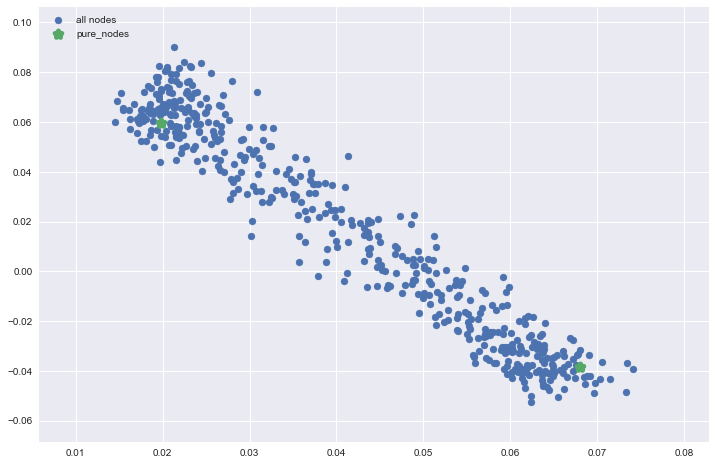

In [26]:
plt.figure(figsize=(12, 8))
plt.scatter(Theta.U_0, Theta.U_1, label="all nodes")
# plt.scatter(usual_nodes.U_0, usual_nodes.U_1, label="usual_nodes", linewidths=0.1)
plt.scatter(pn.U_0, pn.U_1, label="pure_nodes", linewidths=5, marker="*")
# plt.scatter(SPOC_pn.U_0, SPOC_pn.U_1, label="SPOC pnn", linewidths=5)
# plt.scatter(bootstrap_SPOC.U_0, bootstrap_SPOC.U_1, label="bootstrap pnn", marker='*', linewidths=0.6)
plt.legend(loc="upper left")
plt.grid(0.2)
plt.savefig("plot_simplex_eigenvalue_decomposition.png")

In [57]:
direct_std = []
for i in range(500):
    tmp_A = P_to_A(P, reflect=True, seed=i)
    tmp_U, L =  get_U_L(tmp_A, k=2)
    direct_std.append(tmp_U)
direct_std = np.array(direct_std)

In [2]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

def plot_point_cov(points, nstd=2, ax=None, **kwargs):
    """
    Plots an `nstd` sigma ellipse based on the mean and covariance of a point
    "cloud" (points, an Nx2 array).

    Parameters
    ----------
        points : An Nx2 array of the data points.
        nstd : The radius of the ellipse in numbers of standard deviations.
            Defaults to 2 standard deviations.
        ax : The axis that the ellipse will be plotted on. Defaults to the 
            current axis.
        Additional keyword arguments are pass on to the ellipse patch.

    Returns
    -------
        A matplotlib ellipse artist
    """
    pos = points.mean(axis=0)
    cov = np.cov(points, rowvar=False)
    return plot_cov_ellipse(cov, pos, nstd, ax, **kwargs)

def plot_cov_ellipse(cov, pos, nstd=2, ax=None, **kwargs):
    """
    Plots an `nstd` sigma error ellipse based on the specified covariance
    matrix (`cov`). Additional keyword arguments are passed on to the 
    ellipse patch artist.

    Parameters
    ----------
        cov : The 2x2 covariance matrix to base the ellipse on
        pos : The location of the center of the ellipse. Expects a 2-element
            sequence of [x0, y0].
        nstd : The radius of the ellipse in numbers of standard deviations.
            Defaults to 2 standard deviations.
        ax : The axis that the ellipse will be plotted on. Defaults to the 
            current axis.
        Additional keyword arguments are pass on to the ellipse patch.

    Returns
    -------
        A matplotlib ellipse artist
    """
    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:,order]

    if ax is None:
        ax = plt.gca()

    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))

    # Width and height are "full" widths, not radius
    width, height = 2 * nstd * np.sqrt(vals)
    ellip = Ellipse(xy=pos, width=width, height=height, angle=theta, **kwargs)

    ax.add_artist(ellip)
    return ellip

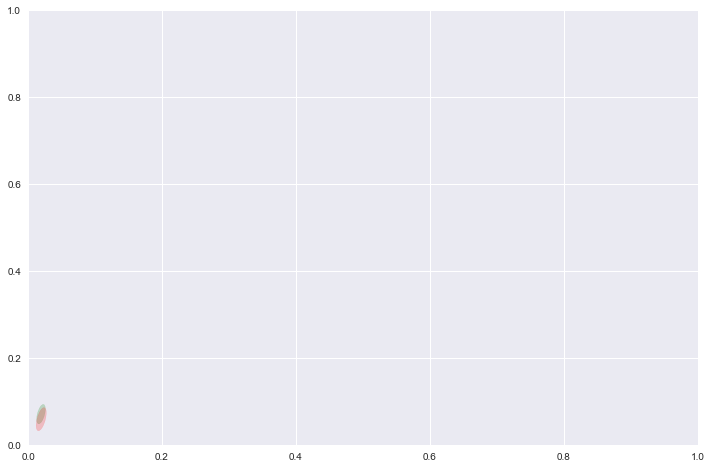

In [58]:
plt.figure(figsize=(12, 8))
# plt.scatter(direct_std[:, pn.index, 0], direct_std[:, pn.index, 1], c="yellow", label = "direct bootstrap",\
#            alpha=0.4, linewidths=0.1)
# plt.scatter(pn.U_0, pn.U_1, label="pure_nodes", linewidths=5, c="r", marker="*")
# plt.scatter(repeats[:, pn.index, 0], repeats[:, pn.index, 1], c="b", label = "bootstrap", alpha=0.4)

for i in indices:
    plot_point_cov(direct_std[:,i], nstd=3, alpha=0.2, color="g")
    plot_point_cov(repeats[:,i], nstd=3, alpha=0.2, color="r")
plt.legend(loc="upper left")
plt.grid(0.2)

In [13]:
C = calculate_C(A, n_clusters=2)
U_mean, std, repeats = calculate_mean_cov_U(A, C, n_repetitions=100, return_bootstrap_matrix=True)

In [14]:
SPOC_pn.index

Int64Index([19, 86], dtype='int64')

In [15]:
np.argsort(-np.linalg.norm(U, axis=1))[:3]

array([ 19,  86, 312])

In [16]:
max_index = np.argsort(-np.linalg.norm(U, axis=1))[0]
v = U[max_index]
cov = np.cov(repeats[:, max_index].T)

In [17]:
diffs = [v - u for u in U]
# dists = np.linalg.norm(diffs, axis=1)
# stds = np.sqrt([dif.dot(cov).dot(dif.T) / (np.linalg.norm(dif) **2) for dif in diffs])
indices = [index for (index, dif) in enumerate(diffs)\
           if dif.dot(np.linalg.inv(cov)).dot(dif.T) < 9]

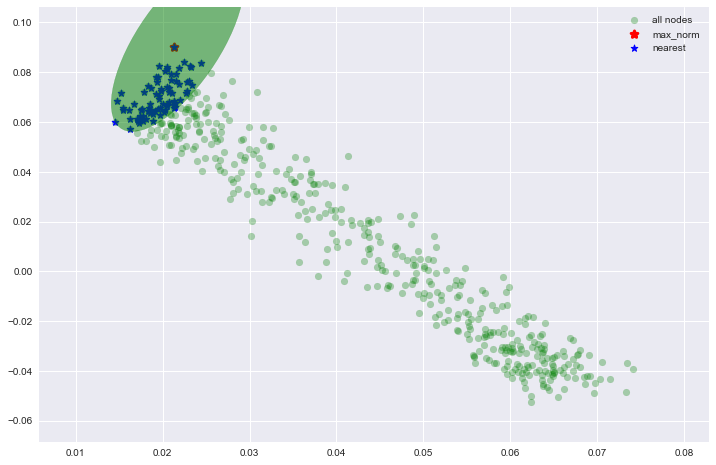

In [18]:
plt.figure(figsize=(12, 8))
plt.scatter(Theta.U_0, Theta.U_1, label="all nodes", linewidths=0.1, c="g", alpha=0.3)
plt.scatter(U[max_index, 0], U[max_index, 1], label="max_norm", marker='*', c="r", linewidths=3)
plt.scatter(U[indices, 0], U[indices, 1], label="nearest", marker='*', c="b", linewidths=1)
# plt.scatter(repeats[:, max_index, 0], repeats[:, max_index, 1], label="bootstrap of selected nodes", linewidths=0.1, alpha=0.3)
plot_point_cov(repeats[:,max_index], nstd=3, alpha=0.5, color="g")

plt.legend(loc="upper right")
plt.grid(0.2)
plt.savefig("pnn_selection.png")

In [20]:
n_clusters = 2
pnn = 5
pn_indices = np.arange(pnn)
B = np.diag([0.5] * n_clusters)

main_error_indices = []
main_error_weights = []
main_error_formula = []
norm_direct_cov = []

for n_nodes in range(50, 550, 50):
    count_err_indices = []
    count_err_weights = []
    count_err_formula = []
    count_norm_cov = []
    
    for count in tqdm_notebook(range(70)):
        Theta = generate_theta(n_nodes, n_clusters, pure_nodes_number=pnn, pure_nodes_indices = pn_indices, seed=count)
        P = Theta.dot(B).dot(Theta.T)
        main_A = P_to_A(P, reflect=True, seed=141414)
        
        direct_std = []
        err_indices = []
        err_weights = []
        err_formula = []
        norm_cov = []

        for i in range(300):
            tmp_A = P_to_A(P, reflect=True, seed=i)
            tmp_U, L =  get_U_L(tmp_A, k=n_clusters)
            direct_std.append(tmp_U)
        direct_std = np.array(direct_std)

        C = calculate_C(main_A, n_clusters)
        
        U_mean, std, bootstrap_matrix_indices = calculate_mean_cov_U(main_A, C, n_repetitions=300, \
                                        return_bootstrap_matrix=True, bootstrap_type = "random_indices")
        
        U_mean, std, bootstrap_matrix_weights = calculate_mean_cov_U(main_A, C, n_repetitions=300, \
                                        return_bootstrap_matrix=True, bootstrap_type = "random_weights")

        for p_index in pn_indices:
            direct_cov = np.cov(direct_std[:, p_index].T)
            bootstrap_cov_indices = np.cov(bootstrap_matrix_indices[:, p_index].T)
            bootstrap_cov_weights = np.cov(bootstrap_matrix_weights[:, p_index].T)
            
            bootstrap_cov_formula = np.zeros((n_clusters, n_clusters))
            for j in range(n_clusters):
                bootstrap_cov_formula += main_A[p_index,j] * np.dot(C[j,:].T, C[j,:])
            
            err_indices.append(np.linalg.norm(direct_cov - bootstrap_cov_indices, ord="fro") / np.linalg.norm(direct_cov))
            err_weights.append(np.linalg.norm(direct_cov - bootstrap_cov_weights, ord="fro") / np.linalg.norm(direct_cov))
            err_formula.append(np.linalg.norm(direct_cov - bootstrap_cov_formula, ord="fro") / np.linalg.norm(direct_cov))
            norm_cov.append(np.linalg.norm(direct_cov))
            
        mean_indices = np.mean(err_indices)
        mean_weights = np.mean(err_weights)
        mean_formula = np.mean(err_formula)
        mean_norm = np.mean(norm_cov)
        
        count_err_indices.append(mean_indices)
        count_err_weights.append(mean_weights)
        count_err_formula.append(mean_formula)
        count_norm_cov.append(mean_norm)
        
    main_error_indices.append(np.mean(count_err_indices))
    main_error_weights.append(np.mean(count_err_weights))
    main_error_formula.append(np.mean(count_err_formula))
    norm_direct_cov.append(np.mean(count_norm_cov))
    
    
    clear_output()
    
    print("n_nodes = {0}, main_err_indices = {1}".format(n_nodes, main_error_indices[-1]))
    print("n_nodes = {0}, main_err_weights = {1}".format(n_nodes, main_error_weights[-1]))
    print("n_nodes = {0}, main_err_formula = {1}".format(n_nodes, main_error_formula[-1]))
    
    plt.figure(figsize=(12,8))
    plt.plot(range(50, n_nodes+50, 50), main_error_indices, label="indices bootstrap")
    plt.plot(range(50, n_nodes+50, 50), main_error_weights, label="weights bootstrap")
    plt.plot(range(50, n_nodes+50, 50), main_error_formula, label="formula")
    
#     plt.plot(range(50, n_nodes+50, 50), norm_direct_cov, label="fro cov norm")
    
    plt.xlabel("n_nodes")
    plt.ylabel("fro error")
    plt.legend(loc="upper right")
    plt.show()
    plt.savefig("covariance_error.png")

Widget Javascript not detected.  It may not be installed or enabled properly.


KeyboardInterrupt: 

In [21]:
import networkx as nx

In [22]:
data = nx.read_gml("polblogs.gml", )

In [23]:
A = nx.to_numpy_matrix(data)
U, L = get_U_L(A, k=2)

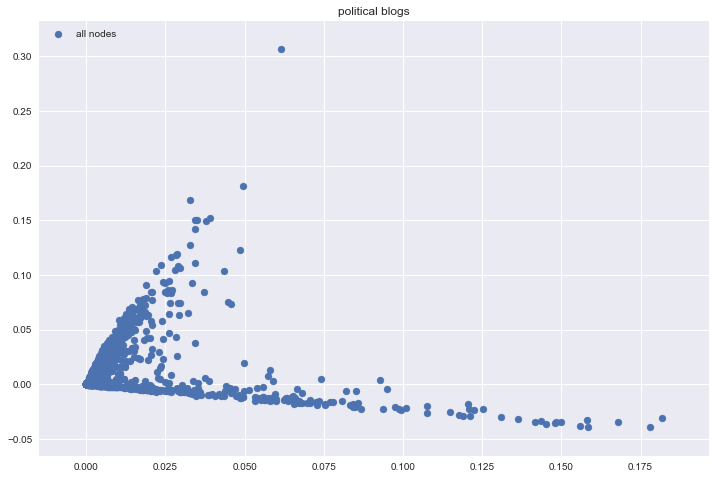

In [24]:
plt.figure(figsize=(12, 8))
plt.scatter(U[:,0], U[:,1], label="all nodes")
plt.legend(loc="upper left")
plt.grid(0.2)
plt.title("political blogs")
plt.savefig("political_blogs.png")

In [10]:
EXP_DATA = pd.DataFrame(columns=["n_nodes", "n_clusters", "pure_nodes_number", "seed", "RES"])
EXP_DATA = EXP_DATA.append({"n_nodes":1,"n_clusters":2,"pure_nodes_number":3,"seed":4}, ignore_index=True)
EXP_DATA

,n_nodes,n_clusters,pure_nodes_number,seed,RES
0,1.0,2.0,3.0,4.0,NaN


In [ ]:
EXP_DATA.groupby()

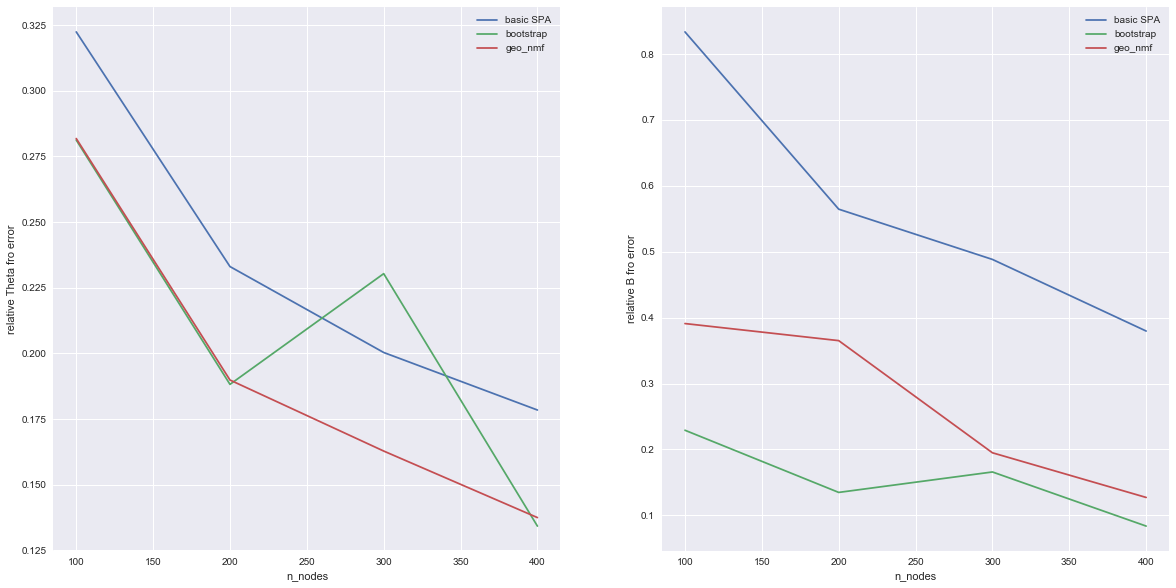

In [14]:
n_clusters = 3
pure_nodes = 3
indices = np.arange(pure_nodes)
B = np.diag([0.5]*n_clusters)

n_repetitions = 3

Theta_err_geo_nmf = []
B_err_geo_nmf = []

Theta_err_SPA = []
B_err_SPA = []
pure_node_coordinates_err_SPA = []

Theta_err_bootstrap = []
B_err_bootstrap = []
pure_node_coordinates_err_bootstrap = []

EXP_DATA = pd.DataFrame(columns=["n_nodes", "n_clusters", "pure_nodes_number", "seed", "method", "matrix", "error"])

for n_nodes in range(100, 500, 100):
    repetitions_Theta_err_geo_nmf = []
    repetitions_B_err_geo_nmf = []
    
    repetitions_Theta_err_SPA = []
    repetitions_B_err_SPA = []
    repetitions_pn_coord_SPA = []
    
    repetitions_Theta_err_bootstrap = []
    repetitions_B_err_bootstrap = []
    repetitions_pn_coord_bootstrap = []
    
    for repeat in tqdm_notebook(range(n_repetitions)):
        Theta = generate_theta(n_nodes, n_clusters, pure_nodes, pure_nodes_indices = indices, seed=repeat)
        P = Theta.dot(B).dot(Theta.T)
        A = P_to_A(P, seed=repeat)
        
        A_mat = matlab.double(A.tolist())
        theta_geo, b_geo = eng.GeoNMF(A_mat, n_clusters, 0.25, 0.95, nargout=2)
        theta_geo = np.array(theta_geo)
        b_geo = np.array(b_geo)
        err, _ = find_permutation_Theta(Theta, theta_geo)
        EXP_DATA = EXP_DATA.append({"n_nodes":n_nodes, "n_clusters":n_clusters, "pure_nodes_number":pure_nodes,\
                "seed":seed, "method":"Geo_NMF", "matrix":"Theta", "error":err}, ignore_index=True)
        repetitions_Theta_err_geo_nmf.append(err)
        err, _ = find_permutation_B(B, b_geo)
        repetitions_B_err_geo_nmf.append(err)
        EXP_DATA = EXP_DATA.append({"n_nodes":n_nodes, "n_clusters":n_clusters, "pure_nodes_number":pure_nodes,\
                "seed":seed, "method":"Geo_NMF", "matrix":"B", "error":err}, ignore_index=True)
        
        
        theta_spa, b_spa, pn_indices_SPA = SPOC(A, n_clusters, return_pure_nodes_indices=True)
        err, _ = find_permutation_Theta(Theta, theta_spa)
        repetitions_Theta_err_SPA.append(err)
        EXP_DATA = EXP_DATA.append({"n_nodes":n_nodes, "n_clusters":n_clusters, "pure_nodes_number":pure_nodes,\
                "seed":seed, "method":"basic_SPA", "matrix":"Theta", "error":err}, ignore_index=True)
        err, _ = find_permutation_B(B, b_spa)
        repetitions_B_err_SPA.append(err)
        EXP_DATA = EXP_DATA.append({"n_nodes":n_nodes, "n_clusters":n_clusters, "pure_nodes_number":pure_nodes,\
                "seed":seed, "method":"basic_SPA", "matrix":"B", "error":err}, ignore_index=True)
        
        theta_bootstrap, b_bootstrap = SPOC_bootstrap(A, n_clusters, n_repetitions=200, std_num=3)
        err, _ = find_permutation_Theta(Theta, theta_bootstrap)
        repetitions_Theta_err_bootstrap.append(err)
        EXP_DATA = EXP_DATA.append({"n_nodes":n_nodes, "n_clusters":n_clusters, "pure_nodes_number":pure_nodes,\
                "seed":seed, "method":"bootstrap_SPA", "matrix":"Theta", "error":err}, ignore_index=True)
        err, _ = find_permutation_B(B, b_bootstrap)
        repetitions_B_err_bootstrap.append(err)
        EXP_DATA = EXP_DATA.append({"n_nodes":n_nodes, "n_clusters":n_clusters, "pure_nodes_number":pure_nodes,\
                "seed":seed, "method":"bootstrap_SPA", "matrix":"B", "error":err}, ignore_index=True)

    Theta_err_SPA.append(np.mean(repetitions_Theta_err_SPA))
    B_err_SPA.append(np.mean(repetitions_B_err_SPA))
    
    Theta_err_bootstrap.append(np.mean(repetitions_Theta_err_bootstrap))
    B_err_bootstrap.append(np.mean(repetitions_B_err_bootstrap))
    
    Theta_err_geo_nmf.append(np.mean(repetitions_Theta_err_geo_nmf))
    B_err_geo_nmf.append(np.mean(repetitions_B_err_geo_nmf))
    
    clear_output()
        
    plt.figure(figsize=(20,10))
    plt.subplot(121)
    plt.plot(range(100, n_nodes+100, 100), Theta_err_SPA, label="basic SPA")
    plt.plot(range(100, n_nodes+100, 100), Theta_err_bootstrap, label="bootstrap")
    plt.plot(range(100, n_nodes+100, 100), Theta_err_geo_nmf, label="geo_nmf")
    plt.xlabel("n_nodes")
    plt.ylabel("relative Theta fro error")
    plt.legend(loc="upper right")
    
    plt.subplot(122)
    plt.plot(range(100, n_nodes+100, 100), B_err_SPA, label="basic SPA")
    plt.plot(range(100, n_nodes+100, 100), B_err_bootstrap, label="bootstrap")
    plt.plot(range(100, n_nodes+100, 100), B_err_geo_nmf, label = "geo_nmf")
    plt.xlabel("n_nodes")
    plt.ylabel("relative B fro error")
    plt.legend(loc="upper right")
    plt.show()
    plt.savefig("n_nodes.png")

In [15]:
EXP_DATA.head()

,n_nodes,n_clusters,pure_nodes_number,seed,method,matrix,error
0,100,3,3,10,Geo_NMF,Theta,0.247903
1,100,3,3,10,Geo_NMF,B,0.328566
2,100,3,3,10,basic_SPA,Theta,0.280230
3,100,3,3,10,basic_SPA,B,1.042615
4,100,3,3,10,bootstrap_SPA,Theta,0.231298


In [35]:
EXP_DATA.groupby(["method", "matrix", "n_nodes"]).error.mean()

method         matrix  n_nodes
Geo_NMF        B       100        0.391063
                       200        0.365160
                       300        0.195007
                       400        0.127248
               Theta   100        0.281804
                       200        0.189884
                       300        0.162848
                       400        0.137521
basic_SPA      B       100        0.833544
                       200        0.564609
                       300        0.488362
                       400        0.379708
               Theta   100        0.322398
                       200        0.233073
                       300        0.200366
                       400        0.178467
bootstrap_SPA  B       100        0.229195
                       200        0.134883
                       300        0.165901
                       400        0.083791
               Theta   100        0.281229
                       200        0.188230
                       

In [4]:
n_nodes = 400
n_clusters = 3
pure_nodes = n_clusters
indices = np.arange(pure_nodes)
B = np.diag([0.4, 0.7, 0.5])
seed = 10


Theta = generate_theta(n_nodes, n_clusters, pure_nodes, pure_nodes_indices = indices, seed=n_nodes)
P = Theta.dot(B).dot(Theta.T)
A = P_to_A(P, seed=0)

A_mat = matlab.double(A.tolist())
theta_geo, b_geo = eng.GeoNMF(A_mat, n_clusters, 0.25, 0.95, nargout=2)
theta_geo = np.array(theta_geo)
err, _ = find_permutation_Theta(Theta, theta_geo)
print("geo nmf error = {}".format(err))

theta_spa, b_spa, pn_indices_SPA = SPOC(A, n_clusters, return_pure_nodes_indices=True)
err, _ = find_permutation_Theta(Theta, theta_spa)
print("basic SPA nmf error = {}".format(err))

theta_bootstrap, b_bootstrap = SPOC_bootstrap(A, n_clusters, n_repetitions=200, std_num=3)
err, _ = find_permutation_Theta(Theta, theta_bootstrap)
print("bootstrap SPA error = {}".format(err))

geo nmf error = 0.137060855051
basic SPA nmf error = 0.165991685575
bootstrap SPA error = 0.139291617648


In [5]:
repeats.shape

(100, 400, 3)

In [4]:
J

[65, 256, 295]

In [10]:
repeats[:,i].shape

(100, 3)

TypeError: return arrays must be of ArrayType

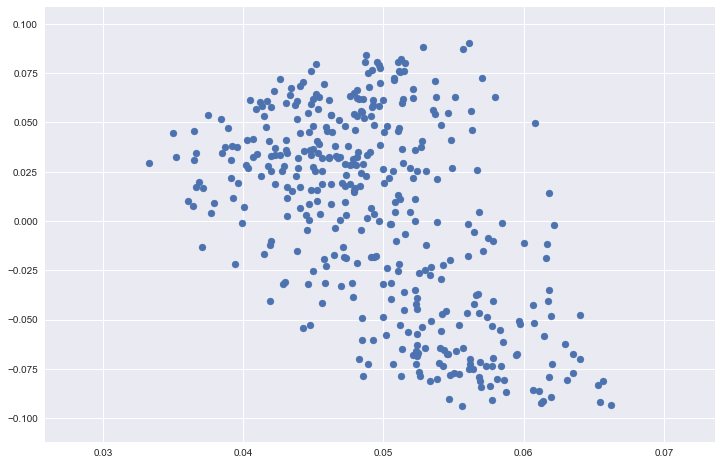

In [8]:
n_nodes = 400
n_clusters = 2
pure_nodes = n_clusters
indices = np.arange(pure_nodes)
B = np.diag([0.5]*n_clusters)
seed = 1

Theta = generate_theta(n_nodes, n_clusters, pure_nodes, pure_nodes_indices = indices, seed=seed)
P = Theta.dot(B).dot(Theta.T)
A = P_to_A(P, seed=18)
U, L = get_U_L(A, n_clusters)
F, B, repeats, J = SPOC_bootstrap(A, n_clusters, n_repetitions=100, return_bootstrap_matrix=True,\
                                 return_pure_nodes_indices=True)

# theta_boot, b_boot = SPOC_bootstrap(A, n_clusters, n_repetitions=200)
# err_boot, _ = find_permutation_Theta(Theta, theta_boot)
# print("bootstrap SPA error = {}".format(err))

plt.figure(figsize=(12,8))
plt.scatter(U[:,0], U[:,1])
for i in J:
    plot_point_cov(repeats[:,i], nstd=3, alpha=0.2, color="r")

In [15]:
n_nodes = 500
n_repetitions = 7

Theta_err_geo_nmf = []
B_err_geo_nmf = []

Theta_err_SPA = []
B_err_SPA = []
pure_node_coordinates_err_SPA = []

Theta_err_bootstrap = []
B_err_bootstrap = []
pure_node_coordinates_err_bootstrap = []

for n_clusters in range(2, 7, 1):
    B = np.diag([0.5]*n_clusters)
    indices = np.arange(n_clusters)
    
    repetitions_Theta_err_geo_nmf = []
    repetitions_B_err_geo_nmf = []
    
    repetitions_Theta_err_SPA = []
    repetitions_B_err_SPA = []
    repetitions_pn_coord_SPA = []
    
    repetitions_Theta_err_bootstrap = []
    repetitions_B_err_bootstrap = []
    repetitions_pn_coord_bootstrap = []
    
    for repeat in tqdm_notebook(range(n_repetitions)):
        Theta = generate_theta(n_nodes=n_nodes, n_clusters=n_clusters, pure_nodes_number=n_clusters, \
                               pure_nodes_indices = indices, seed=repeat)
        P = Theta.dot(B).dot(Theta.T)
        A = P_to_A(P, seed=repeat)
        
        A_mat = matlab.double(A.tolist())
        theta_geo, b_geo = eng.GeoNMF(A_mat, n_clusters, 0.25, 0.95, nargout=2)
        theta_geo = np.array(theta_geo)
        b_geo = np.array(b_geo)
        err, _ = find_permutation_Theta(Theta, theta_geo)
        repetitions_Theta_err_geo_nmf.append(err)
        err, _ = find_permutation_B(B, b_geo)
        repetitions_B_err_geo_nmf.append(err)
        
        theta_spa, b_spa, pn_indices_SPA = SPOC(A, n_clusters, return_pure_nodes_indices=True)
        err, _ = find_permutation_Theta(Theta, theta_spa)
        repetitions_Theta_err_SPA.append(err)
        err, _ = find_permutation_B(B, b_spa)
        repetitions_B_err_SPA.append(err)
        
        theta_bootstrap, b_bootstrap = SPOC_bootstrap(A, n_clusters, n_repetitions=200, std_num=3)
        err, _ = find_permutation_Theta(Theta, theta_bootstrap)
        repetitions_Theta_err_bootstrap.append(err)
        err, _ = find_permutation_B(B, b_bootstrap)
        repetitions_B_err_bootstrap.append(err)

    Theta_err_SPA.append(np.mean(repetitions_Theta_err_SPA))
    B_err_SPA.append(np.mean(repetitions_B_err_SPA))
    
    Theta_err_bootstrap.append(np.mean(repetitions_Theta_err_bootstrap))
    B_err_bootstrap.append(np.mean(repetitions_B_err_bootstrap))
    
    Theta_err_geo_nmf.append(np.mean(repetitions_Theta_err_geo_nmf))
    B_err_geo_nmf.append(np.mean(repetitions_B_err_geo_nmf))
    
    clear_output()
        
    plt.figure(figsize=(20,10))
    plt.subplot(121)
    plt.plot(range(2, n_clusters+1), Theta_err_SPA, label="basic SPA")
    plt.plot(range(2, n_clusters+1), Theta_err_bootstrap, label="bootstrap")
    plt.plot(range(2, n_clusters+1), Theta_err_geo_nmf, label="geo_nmf")
    plt.xlabel("n_nodes")
    plt.ylabel("relative Theta fro error")
    plt.legend(loc="upper right")
    
    plt.subplot(122)
    plt.plot(range(2, n_clusters+1), B_err_SPA, label="basic SPA")
    plt.plot(range(2, n_clusters+1), B_err_bootstrap, label="bootstrap")
    plt.plot(range(2, n_clusters+1), B_err_geo_nmf, label="geo_nmf")
    plt.xlabel("n_nodes")
    plt.ylabel("relative B fro error")
    plt.legend(loc="upper right")
    plt.show()
    plt.savefig("n_clusters.png")

Widget Javascript not detected.  It may not be installed or enabled properly.


KeyboardInterrupt: 

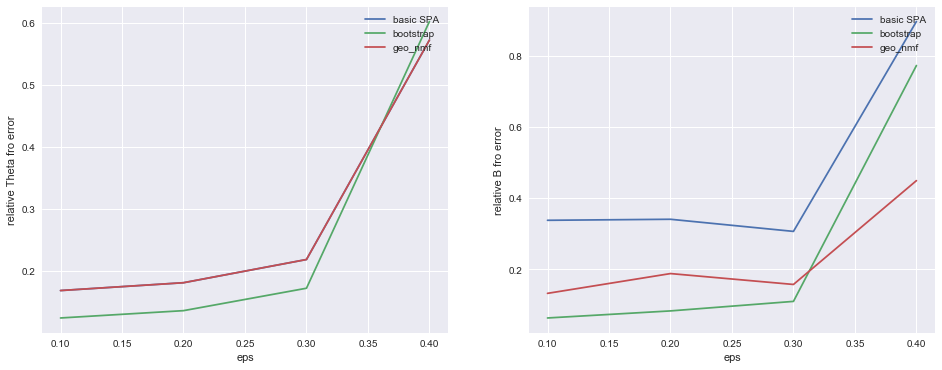

In [7]:
n_nodes = 500
n_clusters = 3
n_repetitions = 5
indices = np.arange(n_clusters)

Theta_err_geo_nmf = []
B_err_geo_nmf = []

Theta_err_SPA = []
B_err_SPA = []
pure_node_coordinates_err_SPA = []

Theta_err_bootstrap = []
B_err_bootstrap = []
pure_node_coordinates_err_bootstrap = []

for eps in np.arange(0.1, 0.5, 0.1):
    B = np.diag([0.5-eps, 0.5, 0.5+eps])
    
    repetitions_Theta_err_geo_nmf = []
    repetitions_B_err_geo_nmf = []
    
    repetitions_Theta_err_SPA = []
    repetitions_B_err_SPA = []
    repetitions_pn_coord_SPA = []
    
    repetitions_Theta_err_bootstrap = []
    repetitions_B_err_bootstrap = []
    repetitions_pn_coord_bootstrap = []
    
    for repeat in tqdm_notebook(range(n_repetitions)):
        Theta = generate_theta(n_nodes=n_nodes, n_clusters=n_clusters, pure_nodes_number=n_clusters, \
                               pure_nodes_indices = indices, seed=repeat)
        P = Theta.dot(B).dot(Theta.T)
        A = P_to_A(P, seed=repeat)
        
        A_mat = matlab.double(A.tolist())
        theta_geo, b_geo = eng.GeoNMF(A_mat, n_clusters, 0.25, 0.95, nargout=2)
        theta_geo = np.array(theta_geo)
        b_geo = np.array(b_geo)
        err, _ = find_permutation_Theta(Theta, theta_geo)
        repetitions_Theta_err_geo_nmf.append(err)
        err, _ = find_permutation_B(B, b_geo)
        repetitions_B_err_geo_nmf.append(err)
        
        theta_spa, b_spa, pn_indices_SPA = SPOC(A, n_clusters, return_pure_nodes_indices=True)
        err, _ = find_permutation_Theta(Theta, theta_spa)
        repetitions_Theta_err_SPA.append(err)
        err, _ = find_permutation_B(B, b_spa)
        repetitions_B_err_SPA.append(err)
        
        theta_bootstrap, b_bootstrap = SPOC_bootstrap(A, n_clusters, n_repetitions=200, std_num=3)
        err, _ = find_permutation_Theta(Theta, theta_bootstrap)
        repetitions_Theta_err_bootstrap.append(err)
        err, _ = find_permutation_B(B, b_bootstrap)
        repetitions_B_err_bootstrap.append(err)
        
    Theta_err_geo_nmf.append(np.mean(repetitions_Theta_err_geo_nmf))
    B_err_geo_nmf.append(np.mean(repetitions_B_err_geo_nmf))
    
    Theta_err_SPA.append(np.mean(repetitions_Theta_err_SPA))
    B_err_SPA.append(np.mean(repetitions_B_err_SPA))
    
    Theta_err_bootstrap.append(np.mean(repetitions_Theta_err_bootstrap))
    B_err_bootstrap.append(np.mean(repetitions_B_err_bootstrap))
    
    clear_output()
        
    plt.figure(figsize=(16,6))
    plt.subplot(121)
    plt.plot(np.arange(0.1, eps+0.05, 0.1), Theta_err_SPA, label="basic SPA")
    plt.plot(np.arange(0.1, eps+0.05, 0.1), Theta_err_bootstrap, label="bootstrap")
    plt.plot(np.arange(0.1, eps+0.05, 0.1), Theta_err_SPA, label="geo_nmf")
    plt.xlabel("eps")
    plt.ylabel("relative Theta fro error")
    plt.legend(loc="upper right")
    
    plt.subplot(122)
    plt.plot(np.arange(0.1, eps+0.05, 0.1), B_err_SPA, label="basic SPA")
    plt.plot(np.arange(0.1, eps+0.05, 0.1), B_err_bootstrap, label="bootstrap")
    plt.plot(np.arange(0.1, eps+0.05, 0.1), B_err_geo_nmf, label="geo_nmf")
    plt.xlabel("eps")
    plt.ylabel("relative B fro error")
    plt.legend(loc="upper right")
    plt.show()
    plt.savefig("eps.png")

In [14]:
Theta_err_bootstrap

[0.089436783003626355, 0.090061635489101899]

In [17]:
np.arange(0.05, eps+0.05, 0.05)

array([ 0.05,  0.1 ,  0.15])

In [2]:
import matlab.engine

In [3]:
eng = matlab.engine.start_matlab()

In [33]:
ret = eng.triarea(1.0,5.0)
print(ret)

2.5


In [7]:
A, Theta, B = generate_a(n_nodes=10, n_clusters=2, pure_nodes_number=2, reflect=True)

In [8]:
A = matlab.double(A.tolist())
ret = eng.GeoNMF(A, 2, 0.25, 0.95)
np.array(ret)

array([[ 0.33463068,  0.66536932],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.04947644,  0.95052356],
       [ 0.78789535,  0.21210465],
       [ 0.05572836,  0.94427164],
       [ 0.17975731,  0.82024269],
       [ 0.        ,  1.        ],
       [ 0.70914645,  0.29085355],
       [ 1.        ,  0.        ]])

In [8]:
matlab.

matlab.double([[0.360340066431,0.639659933569],[0.0,1.0],[1.0,0.0],[0.0,1.0],[0.0,1.0],[1.0,0.0],[0.0868207381946,0.913179261805],[0.0,1.0],[1.0,0.0],[0.0,1.0]])

In [8]:
eng = matlab.engine.start_matlab()
A = matlab.double([1.,2.,3.])
eng.sqrt(A)

matlab.double([[1.0,1.41421356237,1.73205080757]])